# **Comparação de Algoritmos de k-centros 2-aproximados**


## Bibliotecas



In [ ]:
import numpy as np
import pandas as pd

from time import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets, metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import scipy.spatial.distance as dist

## Matriz de Distância de Minkowski

In [ ]:
def minkowski_distance_matrix(points, p=2):
    num_points = len(points)
    dist_matrix = np.zeros((num_points, num_points))

    for i in range(num_points):
        for j in range(num_points):
            dist_matrix[i][j] = np.sum(np.abs(points[i] - points[j])**p)**(1/p)

    return dist_matrix


## **Algoritmos**

### Refinamento do raio ótimo

In [ ]:
def center_finder(dist_matrix, r, k):
    num_points = len(dist_matrix)
    remaining_points = list(range(num_points))
    centers = []

    while len(remaining_points) > 0:
        p = remaining_points[0]
        centers.append(p)
        remaining_points = [
            point for point in remaining_points
            if dist_matrix[point][p] > 2 * r
        ]

    if len(centers) <= k:
        return centers
    else:
        return []

def radius_refiner(dist_matrix, k, conv_param):
    r0 = 0
    r1 = max(
        dist_matrix[i][j]
        for i in range(len(dist_matrix))
        for j in range(len(dist_matrix))
    )

    best_centers = []

    while r1 - r0 > r1 * conv_param:
        r = (r0 + r1) / 2
        centers = center_finder(dist_matrix, r, k)
        if len(centers) > 0:
            r1 = r
            best_centers = centers
        else:
            r0 = r

    return r1*2, best_centers


### Maximiza a distância entre os centros previamente escolhidos

In [ ]:
def max_distance_centers(distance_matrix, k):
    # Seleciona um ponto inicial aleatório como o primeiro centro
    centers = [np.random.randint(len(distance_matrix))]

    while len(centers) < k:
        # Para cada ponto que não é um centro, calcula a menor distância aos centros atuais
        farthest_point = max(
            range(len(distance_matrix)),
            key=lambda point: min(distance_matrix[point][center] for center in centers)
        )
        # Adiciona o ponto mais distante à lista de centros
        centers.append(farthest_point)

    # Calcula o maior raio entre os pontos e os centros selecionados
    max_radius = max(
        min(distance_matrix[i][center] for center in centers)
        for i in range(len(distance_matrix))
    )

    return max_radius, centers

## **Etapa de Extração de Dados**

###Pegando os dados do site https://archive.ics.uci.edu/datasets

In [ ]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

####Bank Marketing

In [ ]:
bank_marketing = fetch_ucirepo(id=222)
X_df = bank_marketing.data.features
y_df = bank_marketing.data.targets

y_df, class_labels = pd.factorize(y_df['y'])

X_df['y'] = y_df
X_df.drop_duplicates(inplace=True)
sampled_df = X_df[['age', 'duration', 'y']].sample(n=700, random_state=42)

y = np.array(sampled_df['y'])
X = np.array(sampled_df.drop(columns=['y']))
k = len(np.unique(class_labels))

dataset_bank = ((X, y), {"n_clusters": k})

####Wine Quality

In [ ]:
wine_quality = fetch_ucirepo(id=186)
X_df = wine_quality.data.features.copy()
y_df = wine_quality.data.targets.copy()

valid_idx = X_df.index
y_df = y_df.loc[valid_idx]

y_df, class_labels = pd.factorize(y_df['quality'])

X_df['quality'] = y_df
X_df.drop_duplicates(inplace=True)
sampled_df = X_df[['fixed_acidity', 'free_sulfur_dioxide', 'quality']].sample(n=700, random_state=42)

y = np.array(sampled_df['quality'])
X = np.array(sampled_df.drop(columns=['quality']))
k = len(np.unique(class_labels))

dataset_wine = ((X, y), {"n_clusters": k})

####Online Shoppers

In [ ]:
online_shoppers = fetch_ucirepo(id=468)
X_df = online_shoppers.data.features.copy()
y_df = online_shoppers.data.targets.copy()

valid_idx = X_df.index
y_df = y_df.loc[valid_idx]
y_df, class_labels = pd.factorize(y_df['Revenue'])

X_df['Revenue'] = y_df
X_df.drop_duplicates(inplace=True)
sampled_df = X_df[['ProductRelated', 'ProductRelated_Duration', 'Revenue']].sample(n=700, random_state=42)

y = np.array(sampled_df['Revenue'])
X = np.array(sampled_df.drop(columns=['Revenue']))
k = len(np.unique(class_labels))

dataset_shoppers = ((X, y), {"n_clusters": k})

####Pen Based

In [ ]:
pen_based = fetch_ucirepo(id=81)
X_df = pen_based.data.features.copy()
y_df = pen_based.data.targets.copy()

valid_idx = X_df.index
y_df = y_df.loc[valid_idx]
y_df, class_labels = pd.factorize(y_df['Class'])

X_df['Class'] = y_df
X_df.drop_duplicates(inplace=True)
sampled_df = X_df[['Attribute1', 'Attribute2', 'Class']].sample(n=700, random_state=42)

y = np.array(sampled_df['Class'])
X = np.array(sampled_df.drop(columns=['Class']))
k = len(np.unique(class_labels))

dataset_pen_based = ((X, y), {"n_clusters": k})

####Magic Gamma Telescope

In [ ]:
magic_gamma_telescope = fetch_ucirepo(id=159)
X_df = magic_gamma_telescope.data.features.copy()
y_df = magic_gamma_telescope.data.targets.copy()

valid_idx = X_df.index
y_df = y_df.loc[valid_idx]
y_df, class_labels = pd.factorize(y_df['class'])

X_df['class'] = y_df
X_df.drop_duplicates(inplace=True)
sampled_df = X_df[['fLength', 'fWidth', 'class']].sample(n=700, random_state=42)

y = np.array(sampled_df['class'])
X = np.array(sampled_df.drop(columns=['class']))
k = len(np.unique(class_labels))

dataset_magic_gamma = ((X, y), {"n_clusters": k})

####Rice (Cammeo and Osmancik)

In [ ]:
rice = fetch_ucirepo(id=545)
X_df = rice.data.features.copy()
y_df = rice.data.targets.copy()

valid_idx = X_df.index
y_df = y_df.loc[valid_idx]
y_df, class_labels = pd.factorize(y_df['Class'])

X_df['Class'] = y_df
X_df.drop_duplicates(inplace=True)
sampled_df = X_df[['Perimeter', 'Major_Axis_Length', 'Class']].sample(n=700, random_state=42)

y = np.array(sampled_df['Class'])
X = np.array(sampled_df.drop(columns=['Class']))
k = len(np.unique(class_labels))

dataset_rice = ((X, y), {"n_clusters": k})

####Shuttle

In [ ]:
shuttle = fetch_ucirepo(id=148)
X_df = shuttle.data.features.copy()
y_df = shuttle.data.targets.copy()

y_df, class_labels = pd.factorize(y_df['class'])

X_df['class'] = y_df
X_df.drop_duplicates(inplace=True)
sampled_df = X_df[['Bypass', 'Bpv Close', 'class']].sample(n=700, random_state=42)

y = np.array(sampled_df['class'])
X = np.array(sampled_df.drop(columns=['class']))
k = len(np.unique(class_labels))

dataset_shuttle = ((X, y), {"n_clusters": k})

####Skin Segmentation

In [ ]:
skin_seg = fetch_ucirepo(id=229)
X_df = skin_seg.data.features.copy()
y_df = skin_seg.data.targets.copy()

y_df, class_labels = pd.factorize(y_df['y'])

X_df['y'] = y_df
X_df.drop_duplicates(inplace=True)
sampled_df = X_df[['B', 'G', 'y']].sample(n=700, random_state=42)

y = np.array(sampled_df['y'])
X = np.array(sampled_df.drop(columns=['y']))
k = len(np.unique(class_labels))

dataset_skin_seg = ((X, y), {"n_clusters": k})

####Dry Bean

In [ ]:
dry_bean = fetch_ucirepo(id=602)
X_df = dry_bean.data.features.copy()
y_df = dry_bean.data.targets.copy()

y_df, class_labels = pd.factorize(y_df['Class'])

X_df['Class'] = y_df
X_df.drop_duplicates(inplace=True)
sampled_df = X_df[['Area', 'Perimeter', 'Class']].sample(n=700, random_state=42)

y = np.array(sampled_df['Class'])
X = np.array(sampled_df.drop(columns=['Class']))
k = len(np.unique(class_labels))

dataset_dry_bean = ((X, y), {"n_clusters": k})

####Predict Students' Dropout and Academic Success

In [ ]:
predict = fetch_ucirepo(id=697)
X_df = predict.data.features
y_df = predict.data.targets

y_df, class_labels = pd.factorize(y_df['Target'])

X_df['Target'] = y_df
X_df.drop_duplicates(inplace=True)
sampled_df = X_df[['Application mode', 'Previous qualification (grade)', 'Target']].sample(n=700, random_state=42)

y = np.array(sampled_df['Target'])
X = np.array(sampled_df.drop(columns=['Target']))
k = len(np.unique(class_labels))

dataset_predict = ((X, y), {"n_clusters": k})

### Juntando todos os datasets do uci

In [ ]:
datasets_list_uci = [dataset_bank, dataset_wine, dataset_shoppers, dataset_pen_based, dataset_magic_gamma,
                     dataset_rice, dataset_shuttle, dataset_skin_seg, dataset_dry_bean, dataset_predict]

## Gerando o conjunto de dados do skicit-learn

In [ ]:
# Parâmetros
n_samples = 500
seed = 30

noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)

# Dados anisotrópicos
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# Blobs com variância variada
varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

moons_with_noise = datasets.make_moons(n_samples=n_samples, noise=0.2, random_state=seed)
blobs_varied_dispersion = datasets.make_blobs(n_samples=n_samples, centers=5, cluster_std=[0.5, 1.0, 1.5, 2.0, 2.5], random_state=seed)
circles_tight = datasets.make_circles(n_samples=n_samples, factor=0.8, noise=0.0, random_state=seed)
moons_wide_noise = datasets.make_moons(n_samples=n_samples, noise=0.7, random_state=seed)
blobs_wide_dispersion = datasets.make_blobs(n_samples=n_samples, centers=2, cluster_std=[0.1, 5.0], random_state=seed)

datasets_list_skicit = [
    (noisy_circles, {"n_clusters": 3}),
    (noisy_moons, {"n_clusters": 2}),
    (blobs, {"n_clusters": 3}),
    (aniso, {"n_clusters": 3}),
    (varied, {"n_clusters": 3}),
    (moons_with_noise, {"n_clusters": 2}),
    (blobs_varied_dispersion, {"n_clusters": 5}),
    (circles_tight, {"n_clusters": 3}),
    (moons_wide_noise, {"n_clusters": 3}),
    (blobs_wide_dispersion, {"n_clusters": 2})
]

## Gerando dados usando a distribuição normal multivariada

In [ ]:
# Função para gerar dados com normal multivariada
def generate_multivariate_normal_data(n_samples, centers, std_devs, random_state):
    data_list = []
    labels_list = []

    np.random.seed(random_state)

    for i, (center, std_dev) in enumerate(zip(centers, std_devs)):
        X, y = datasets.make_blobs(n_samples=n_samples, centers=[center], cluster_std=std_dev, random_state=random_state + i)
        data_list.append(X)
        labels_list.append(y + i)

    X_all = np.vstack(data_list)
    y_all = np.hstack(labels_list)

    return X_all, y_all

# Função para gerar centros e desvios padrão aleatórios
def generate_random_centers_and_std_devs(n_centers, n_features, seed):
    np.random.seed(seed)
    centers = np.random.uniform(low=-10, high=10, size=(n_centers, n_features))
    std_devs = np.random.uniform(low=0.1, high=2.0, size=n_centers)
    return centers, std_devs

# Parâmetros
n_samples = 500
n_datasets = 10
seed = 42

datasets_list_normal = []

for i in range(n_datasets):
    centers, std_devs = generate_random_centers_and_std_devs(n_centers=3, n_features=2, seed=seed + i)
    X, y = generate_multivariate_normal_data(n_samples=n_samples, centers=centers, std_devs=std_devs, random_state=seed + i)

    datasets_list_normal.append(((X, y), {"n_clusters": len(centers)}))

## **Etapa de Testes**

### Definindo a largura da busca do algoritmo de refinamento


In [ ]:
convergence_param = [(2.236 ** i/100) for i in range (5)]  # [0.01, 0.02236, 0.04999, 0.11179, 0.24996]

### Função para truncar o resultado

In [ ]:
def truncate(value, decimals=3):
    factor = 10.0 ** decimals
    return np.floor(value * factor) / factor

### Comparação entre os modelos de clusterização

In [ ]:
def models_comparator(datasets_list, p):
    results = []

    for i, (dataset, params) in enumerate(datasets_list):
        X, y = dataset

        # Normaliza o dataset
        X = StandardScaler().fit_transform(X)

        # Calcula a matriz de distância
        dist_matrix = minkowski_distance_matrix(X, p)

        kmeans_radius, kmeans_times, kmeans_silhouettes, kmeans_aris = [], [], [], []
        max_dist_radius, max_dist_times, max_dist_silhouettes, max_dist_aris = [], [], [], []
        refiner_results = {param: {'radius': [], 'times': [], 'silhouettes': [], 'aris': []} for param in convergence_param}

        print(f"Executando experimentos no dataset {i + 1}/10")

        for _ in range(30):

            # KMeans
            kmeans = KMeans(n_clusters=params["n_clusters"], random_state=42, n_init=30)
            start_time = time()
            kmeans.fit(X)
            end_time = time()

            distances_to_centers = dist.cdist(X, kmeans.cluster_centers_, metric='euclidean')
            kmeans_rad = np.max(np.min(distances_to_centers, axis=1))
            processing_time_kmeans = end_time - start_time
            silhouette_score_kmeans = metrics.silhouette_score(X, kmeans.labels_, metric='euclidean')
            adjusted_rand_index_kmeans = metrics.adjusted_rand_score(y, kmeans.labels_)

            kmeans_radius.append(kmeans_rad)
            kmeans_times.append(processing_time_kmeans)
            kmeans_silhouettes.append(silhouette_score_kmeans)
            kmeans_aris.append(adjusted_rand_index_kmeans)

            # Max Distance Centers
            start_time = time()
            max_radius, centers = max_distance_centers(dist_matrix, params["n_clusters"])
            end_time = time()
            processing_time_max_distance = end_time - start_time
            labels_max_distance = np.argmin([[dist_matrix[i][center] for center in centers] for i in range(len(dist_matrix))], axis=1)
            silhouette_score_max_distance = metrics.silhouette_score(X, labels_max_distance, metric='euclidean')
            adjusted_rand_index_max_distance = metrics.adjusted_rand_score(y, labels_max_distance)

            max_dist_radius.append(max_radius)
            max_dist_times.append(processing_time_max_distance)
            max_dist_silhouettes.append(silhouette_score_max_distance)
            max_dist_aris.append(adjusted_rand_index_max_distance)

            # Radius Refiner
            for param in convergence_param:
                start_time = time()
                refined_radius, centers = radius_refiner(dist_matrix, params["n_clusters"], param)
                end_time = time()
                processing_time_refiner = end_time - start_time
                labels_refiner = np.argmin([[dist_matrix[i][center] for center in centers] for i in range(len(dist_matrix))], axis=1)
                silhouette_score_refiner = metrics.silhouette_score(X, labels_refiner, metric='euclidean')
                adjusted_rand_index_refiner = metrics.adjusted_rand_score(y, labels_refiner)

                refiner_results[param]['radius'].append(refined_radius)
                refiner_results[param]['times'].append(processing_time_refiner)
                refiner_results[param]['silhouettes'].append(silhouette_score_refiner)
                refiner_results[param]['aris'].append(adjusted_rand_index_refiner)

        # Calcula as médias e desvios-padrão
        results.append({
            'Dataset': f"{i + 1}",
            'Algorithm': 'KMeans',
            'Mean Radius': truncate(np.mean(kmeans_radius)),
            'Std Radius': truncate(np.std(kmeans_radius)),
            'Mean Time': truncate(np.mean(kmeans_times)),
            'Std Time': truncate(np.std(kmeans_times)),
            'Mean Silhouette': truncate(np.mean(kmeans_silhouettes)),
            'Std Silhouette': truncate(np.std(kmeans_silhouettes)),
            'Mean ARI': truncate(np.mean(kmeans_aris)),
            'Std ARI': truncate(np.std(kmeans_aris))
        })

        results.append({
            'Dataset': f"{i + 1}",
            'Algorithm': 'Max Distance Centers',
            'Mean Radius': truncate(np.mean(max_dist_radius)),
            'Std Radius': truncate(np.std(max_dist_radius)),
            'Mean Time': truncate(np.mean(max_dist_times)),
            'Std Time': truncate(np.std(max_dist_times)),
            'Mean Silhouette': truncate(np.mean(max_dist_silhouettes)),
            'Std Silhouette': truncate(np.std(max_dist_silhouettes)),
            'Mean ARI': truncate(np.mean(max_dist_aris)),
            'Std ARI': truncate(np.std(max_dist_aris))
        })

        for param in convergence_param:
            results.append({
                'Dataset': f"{i + 1}",
                'Algorithm': f'Radius Refiner (conv_param={param:.2f})',
                'Mean Radius': truncate(np.mean(refiner_results[param]['radius'])),
                'Std Radius': truncate(np.std(refiner_results[param]['radius'])),
                'Mean Time': truncate(np.mean(refiner_results[param]['times'])),
                'Std Time': truncate(np.std(refiner_results[param]['times'])),
                'Mean Silhouette': truncate(np.mean(refiner_results[param]['silhouettes'])),
                'Std Silhouette': truncate(np.std(refiner_results[param]['silhouettes'])),
                'Mean ARI': truncate(np.mean(refiner_results[param]['aris'])),
                'Std ARI': truncate(np.std(refiner_results[param]['aris']))
            })

    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
result_uci_p1 = models_comparator(datasets_list_uci, 1)

Executando experimentos no dataset 1/10
Executando experimentos no dataset 2/10
Executando experimentos no dataset 3/10
Executando experimentos no dataset 4/10
Executando experimentos no dataset 5/10
Executando experimentos no dataset 6/10
Executando experimentos no dataset 7/10
Executando experimentos no dataset 8/10
Executando experimentos no dataset 9/10
Executando experimentos no dataset 10/10


In [ ]:
result_uci_p2 = models_comparator(datasets_list_uci, 2)

Executando experimentos no dataset 1/10
Executando experimentos no dataset 2/10
Executando experimentos no dataset 3/10
Executando experimentos no dataset 4/10
Executando experimentos no dataset 5/10
Executando experimentos no dataset 6/10
Executando experimentos no dataset 7/10
Executando experimentos no dataset 8/10
Executando experimentos no dataset 9/10
Executando experimentos no dataset 10/10


In [ ]:
result_skicit_p1 = models_comparator(datasets_list_skicit, 1)

Executando experimentos no dataset 1/10
Executando experimentos no dataset 2/10
Executando experimentos no dataset 3/10
Executando experimentos no dataset 4/10
Executando experimentos no dataset 5/10
Executando experimentos no dataset 6/10
Executando experimentos no dataset 7/10
Executando experimentos no dataset 8/10
Executando experimentos no dataset 9/10
Executando experimentos no dataset 10/10


In [ ]:
result_skicit_p2 = models_comparator(datasets_list_skicit, 2)

Executando experimentos no dataset 1/10
Executando experimentos no dataset 2/10
Executando experimentos no dataset 3/10
Executando experimentos no dataset 4/10
Executando experimentos no dataset 5/10
Executando experimentos no dataset 6/10
Executando experimentos no dataset 7/10
Executando experimentos no dataset 8/10
Executando experimentos no dataset 9/10
Executando experimentos no dataset 10/10


In [ ]:
result_normal_p1 = models_comparator(datasets_list_normal, 1)

Executando experimentos no dataset 1/10
Executando experimentos no dataset 2/10
Executando experimentos no dataset 3/10
Executando experimentos no dataset 4/10
Executando experimentos no dataset 5/10
Executando experimentos no dataset 6/10
Executando experimentos no dataset 7/10
Executando experimentos no dataset 8/10
Executando experimentos no dataset 9/10
Executando experimentos no dataset 10/10


In [ ]:
result_normal_p2 = models_comparator(datasets_list_normal, 2)

Executando experimentos no dataset 1/10
Executando experimentos no dataset 2/10
Executando experimentos no dataset 3/10
Executando experimentos no dataset 4/10
Executando experimentos no dataset 5/10
Executando experimentos no dataset 6/10
Executando experimentos no dataset 7/10
Executando experimentos no dataset 8/10
Executando experimentos no dataset 9/10
Executando experimentos no dataset 10/10


## Plotando os resultados

In [ ]:
def plot_comparison(results_df):
    # Configuração do estilo dos gráficos
    sns.set(style="whitegrid")

    # Gráfico de comparação de raio médio
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x='Dataset', y='Mean Radius', hue='Algorithm', errorbar='sd', palette='muted', width=0.7)
    plt.title('Comparação do Raio Ótimo Médio dos Algoritmos por Dataset')
    plt.xlabel('Dataset')
    plt.ylabel('Raio Ótimo Médio')
    plt.legend(title='Algoritmo', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Gráfico de comparação do tempo médio
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x='Dataset', y='Mean Time', hue='Algorithm', errorbar='sd', palette='muted', width=0.7)
    plt.title('Comparação do Tempo Médio dos Algoritmos por Dataset')
    plt.xlabel('Dataset')
    plt.ylabel('Tempo Médio (segundos)')
    plt.legend(title='Algoritmo', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Gráfico de comparação da Silhouette Score média
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x='Dataset', y='Mean Silhouette', hue='Algorithm', errorbar='sd', palette='muted', width=0.7)
    plt.title('Comparação da Silhouette Score Média dos Algoritmos por Dataset')
    plt.xlabel('Dataset')
    plt.ylabel('Silhouette Score Médio')
    plt.legend(title='Algoritmo', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Gráfico de comparação do Adjusted Rand Index (ARI) médio
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x='Dataset', y='Mean ARI', hue='Algorithm', errorbar='sd', palette='muted', width=0.7)
    plt.title('Comparação do Adjusted Rand Index Médio dos Algoritmos por Dataset')
    plt.xlabel('Dataset')
    plt.ylabel('Adjusted Rand Index Médio')
    plt.legend(title='Algoritmo', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### p=1

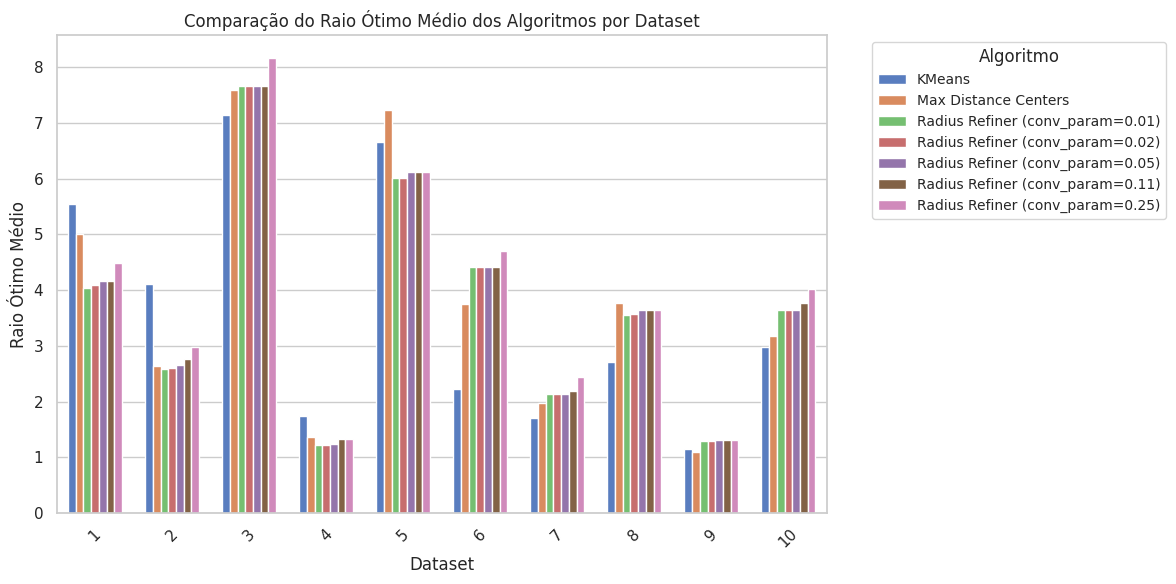

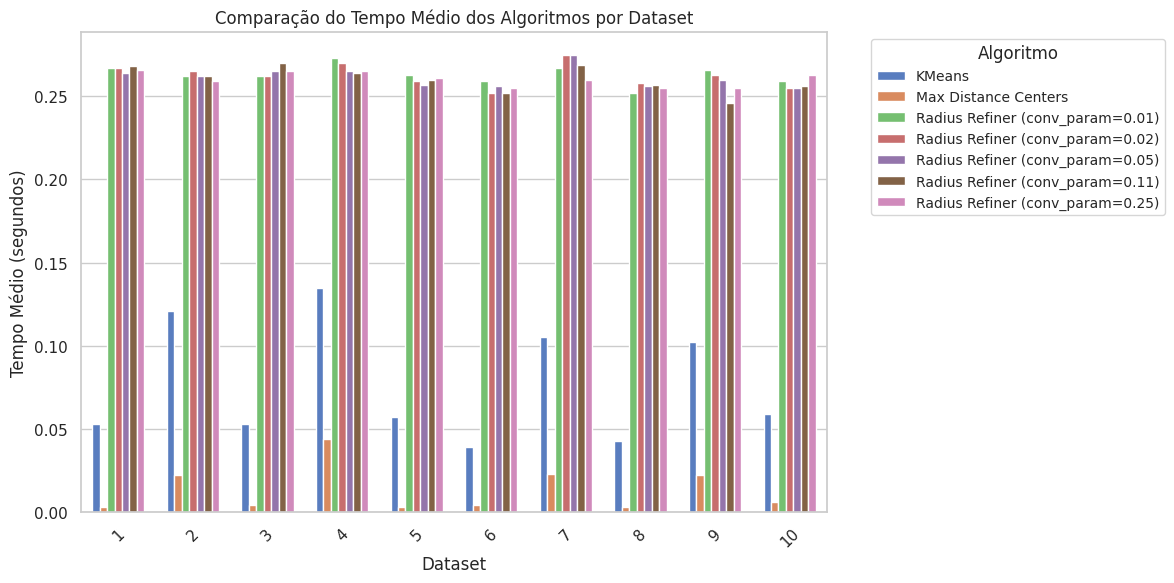

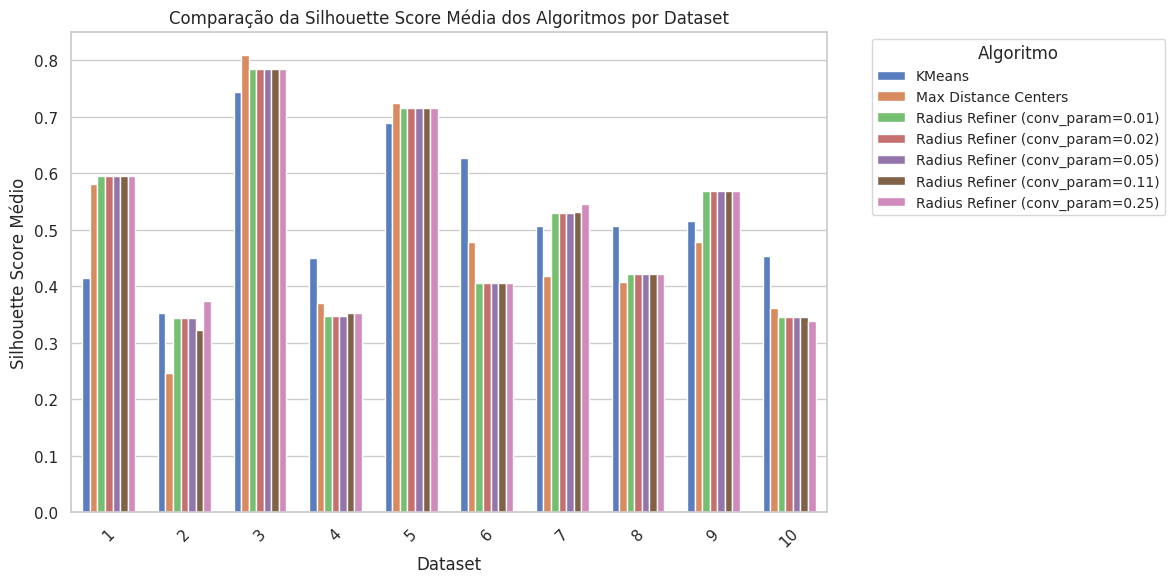

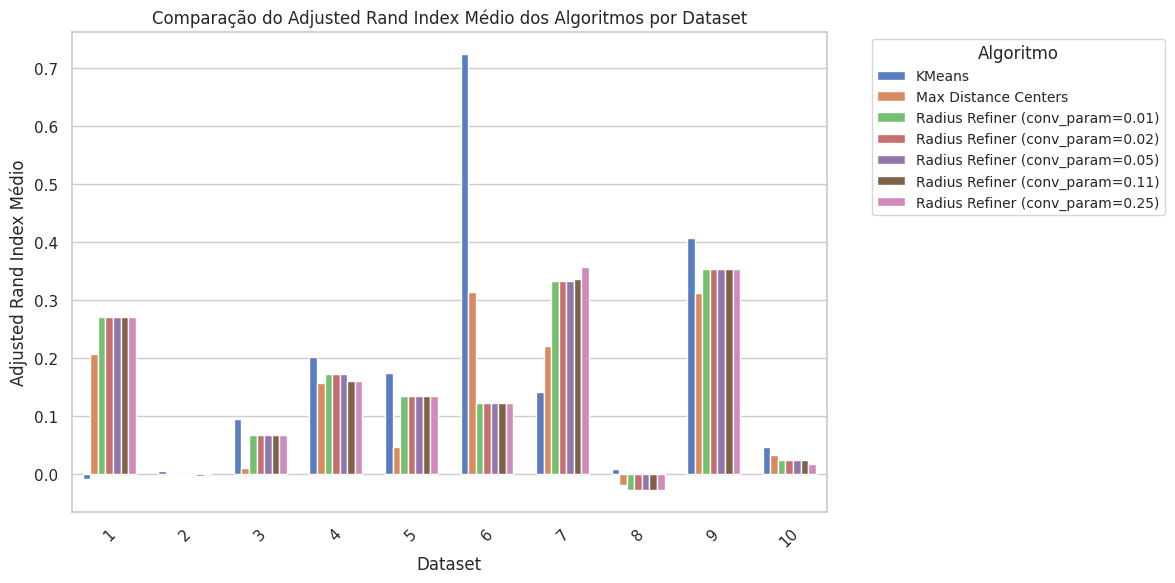

In [ ]:
plot_comparison(result_uci_p1)

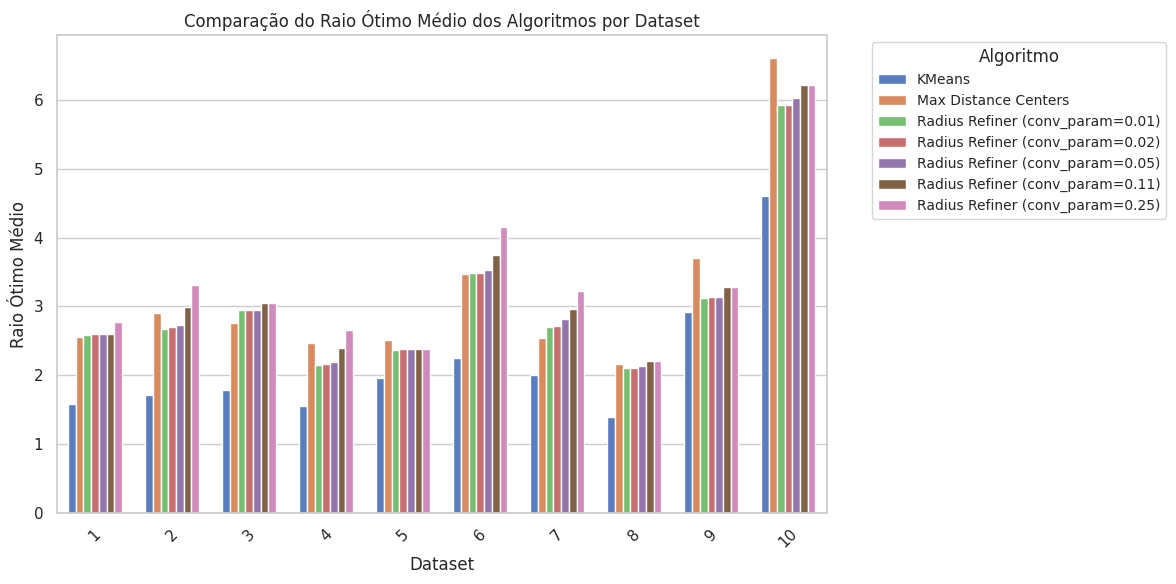

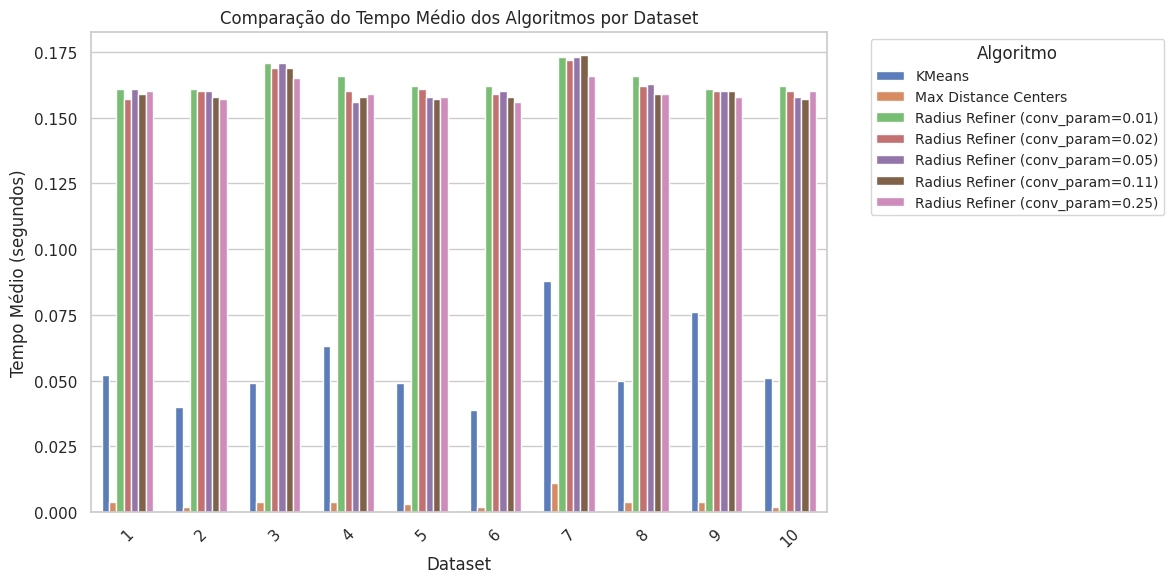

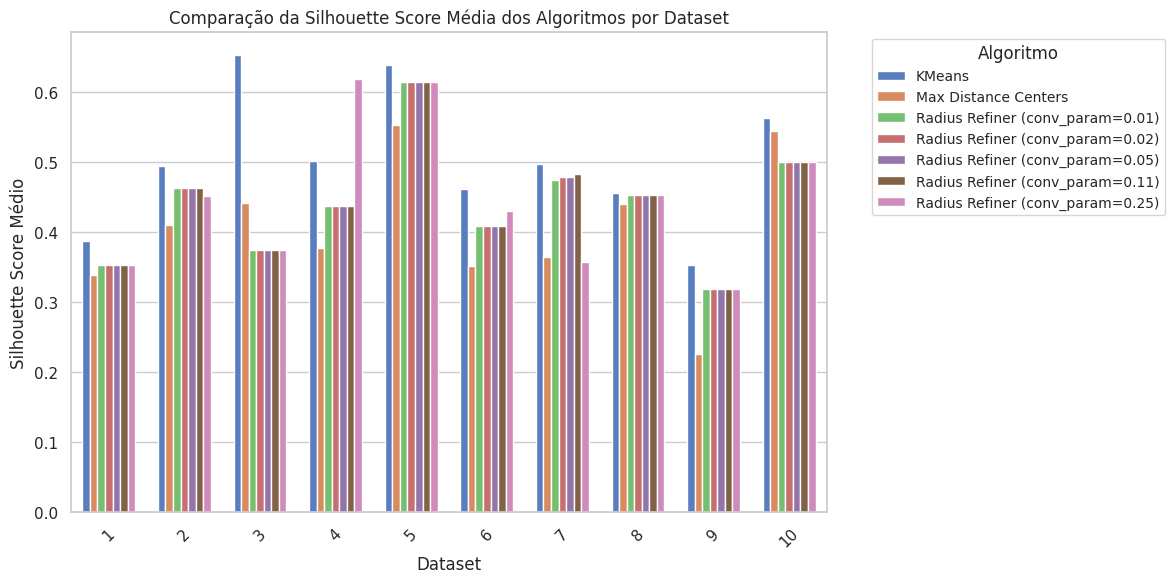

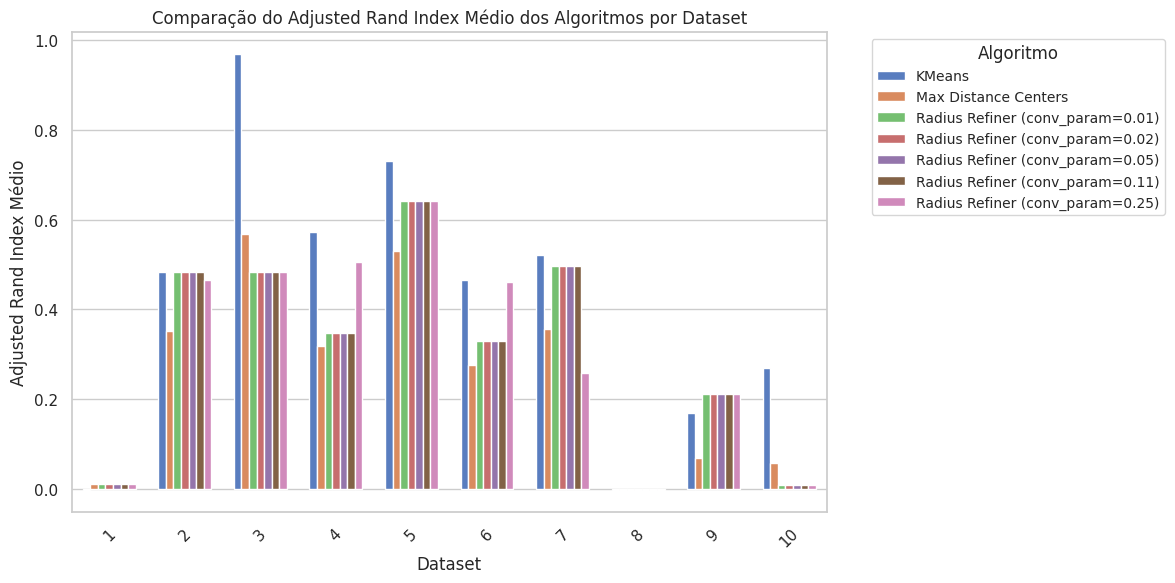

In [ ]:
plot_comparison(result_skicit_p1)

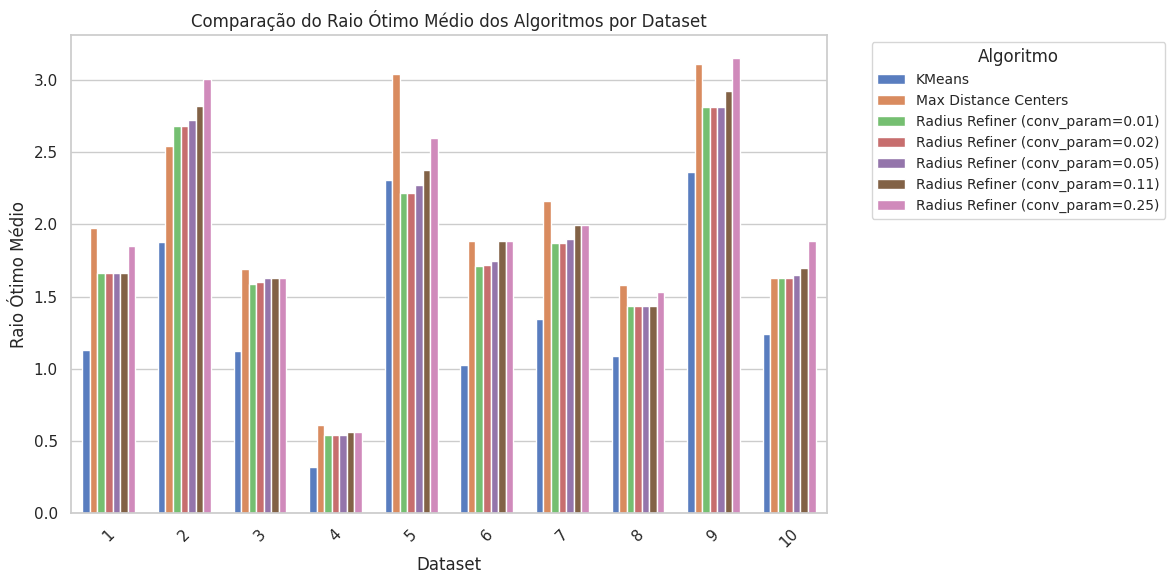

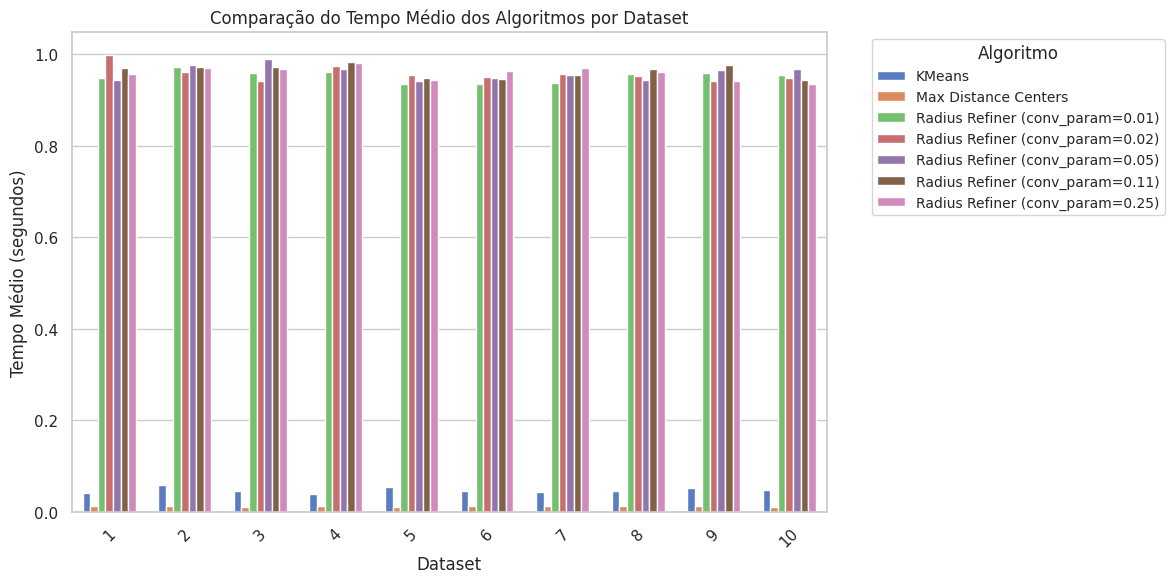

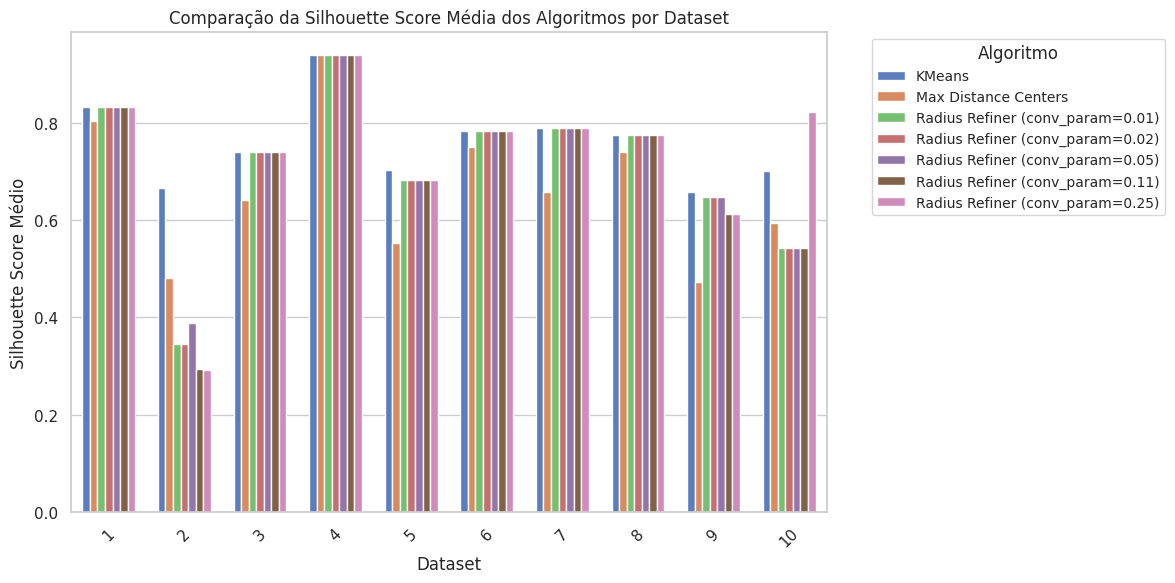

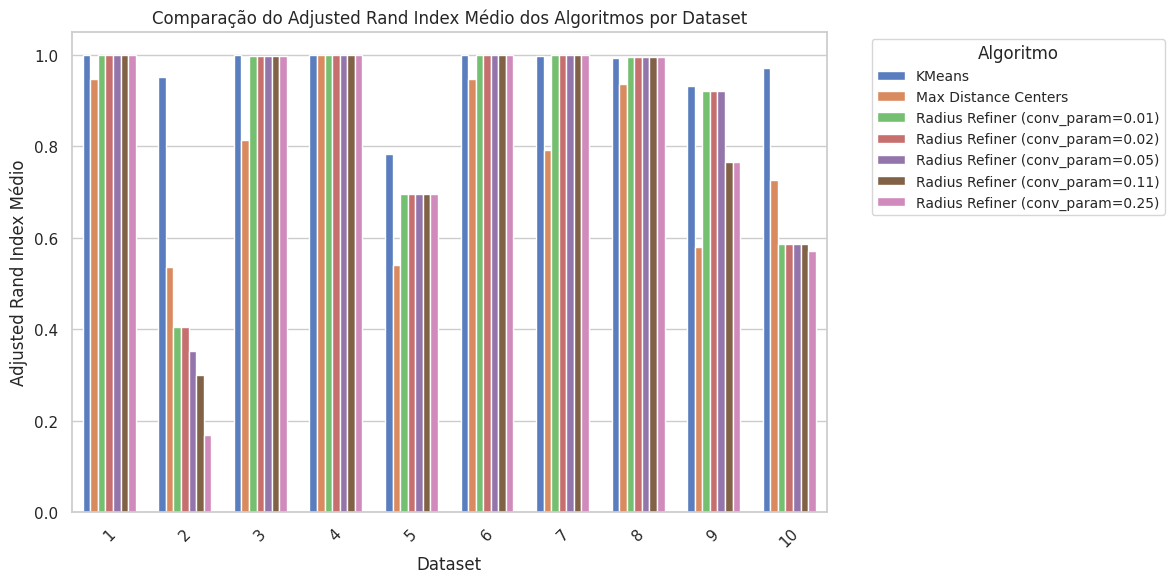

In [ ]:
plot_comparison(result_normal_p1)

### p=2

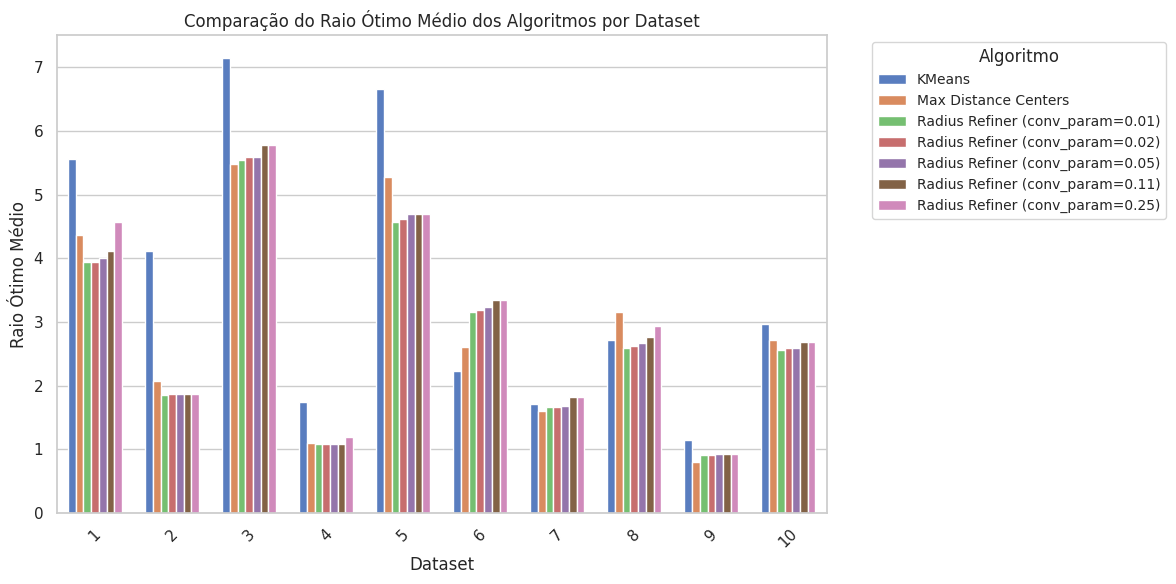

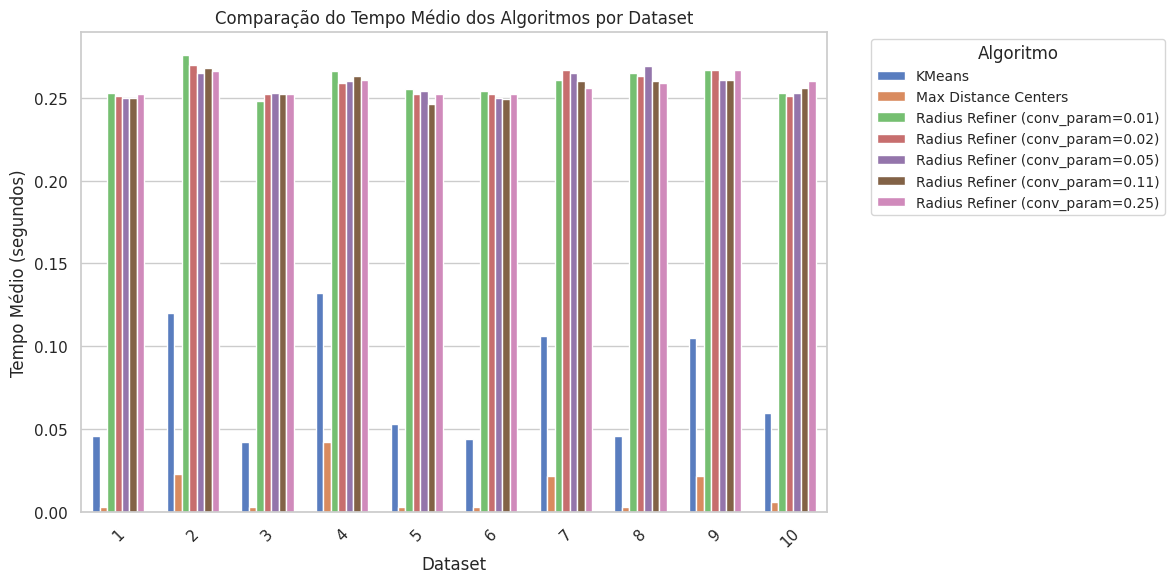

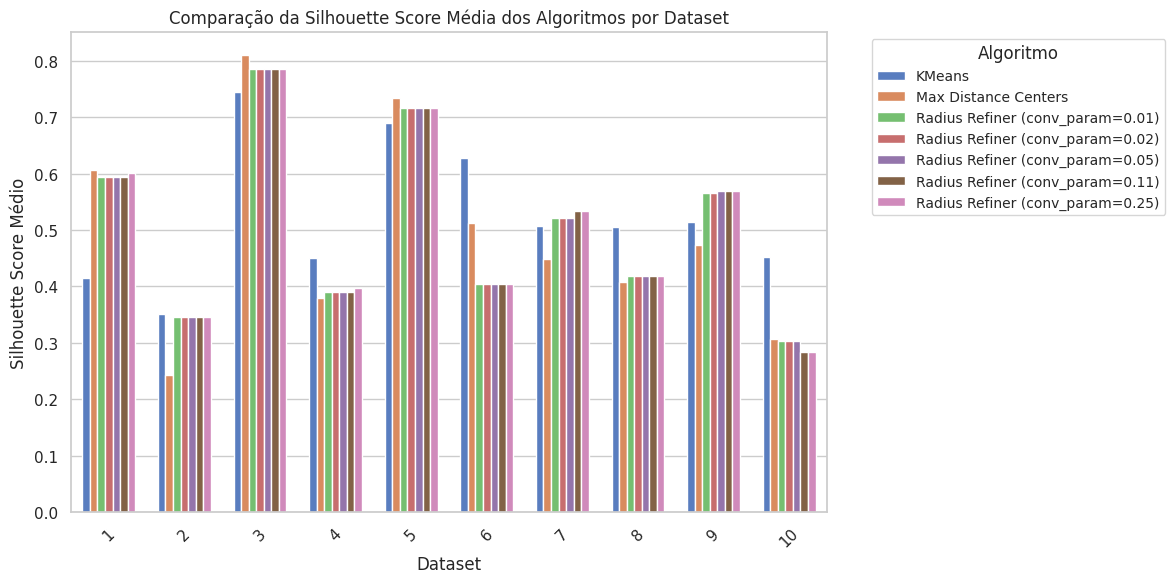

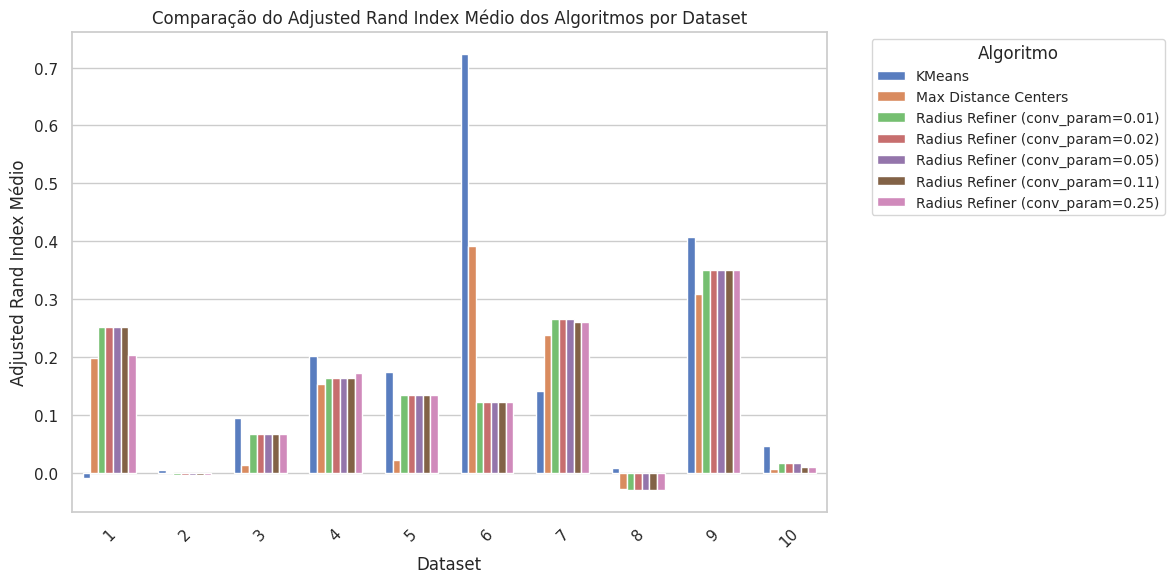

In [ ]:
plot_comparison(result_uci_p2)

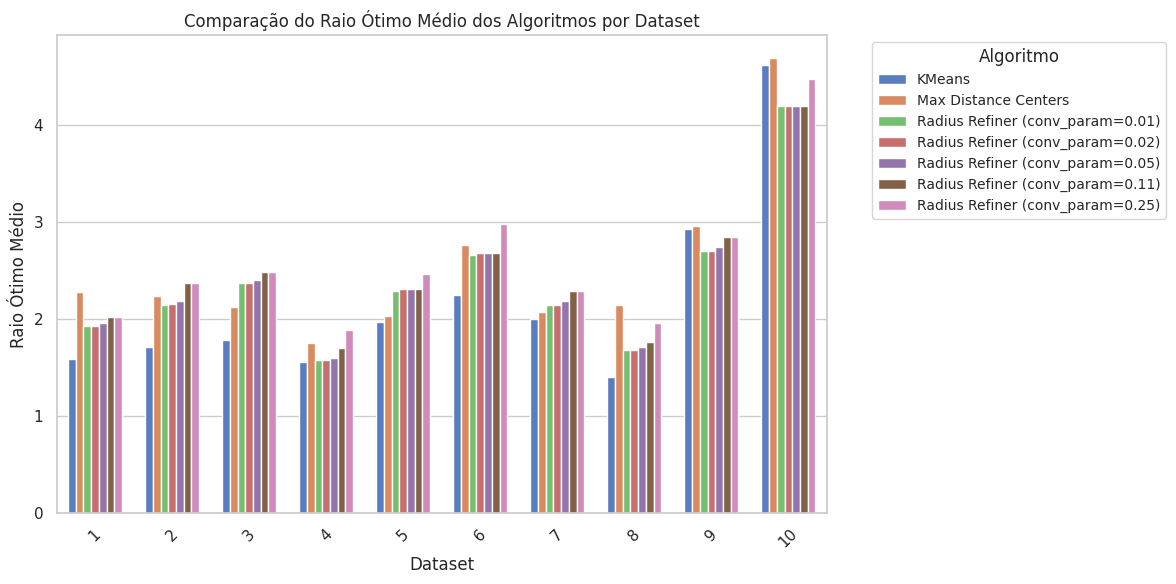

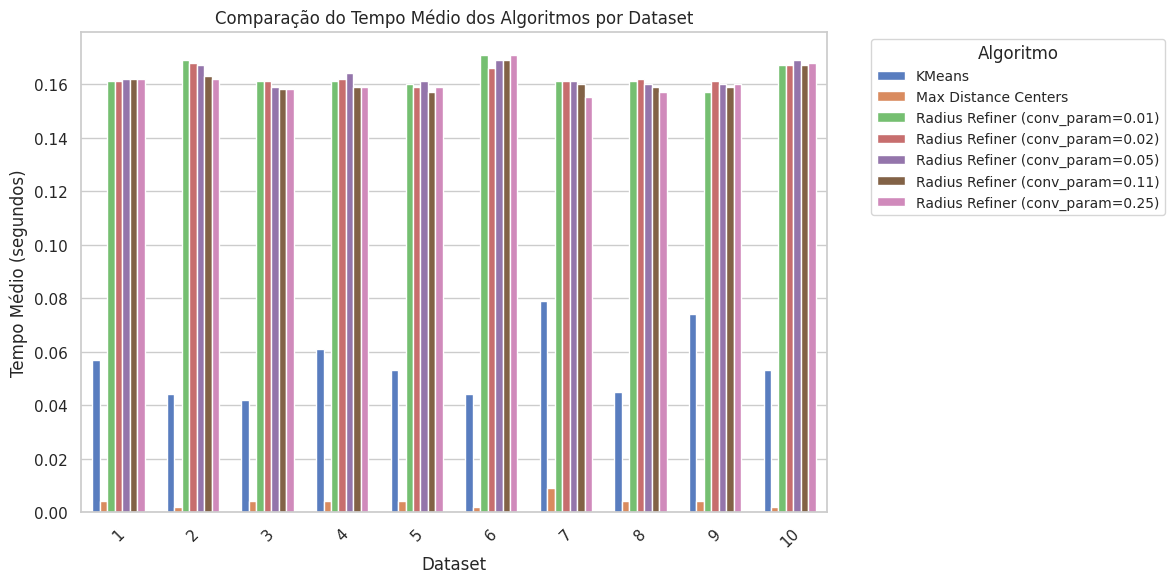

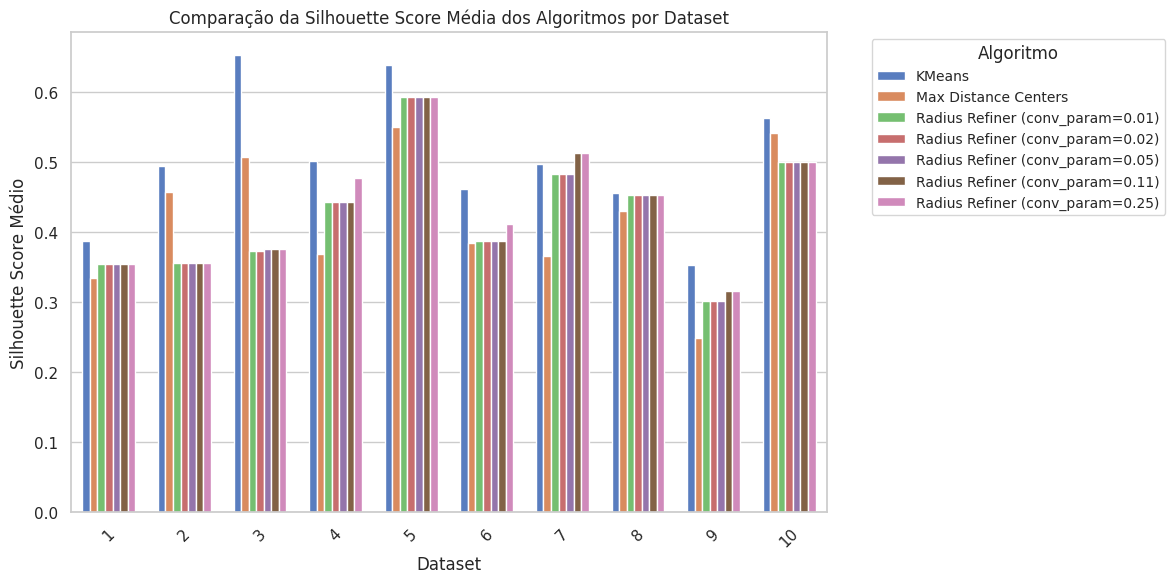

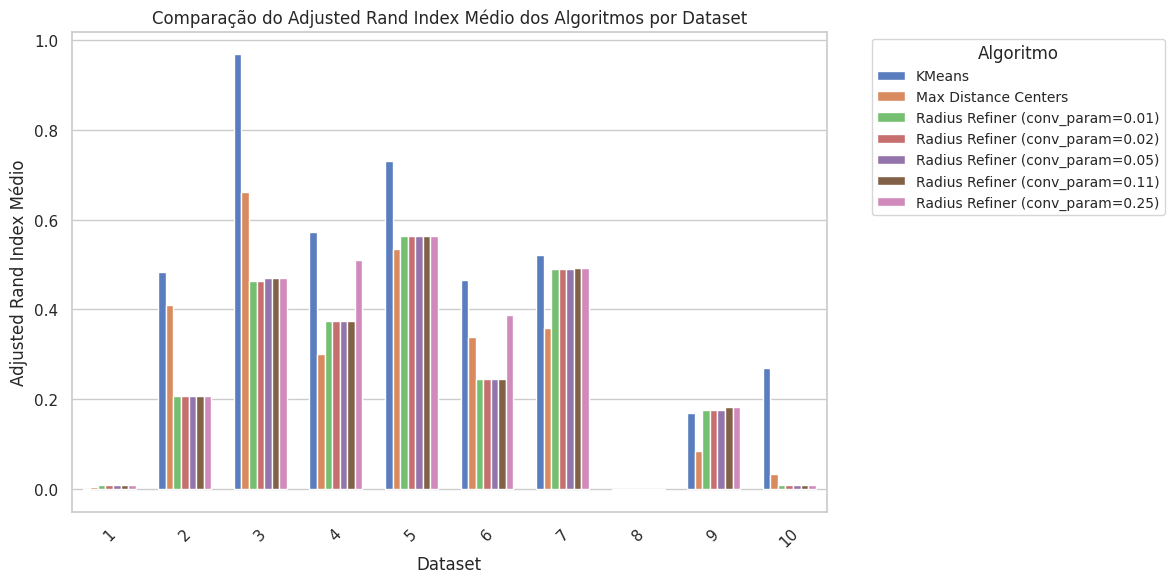

In [ ]:
plot_comparison(result_skicit_p2)

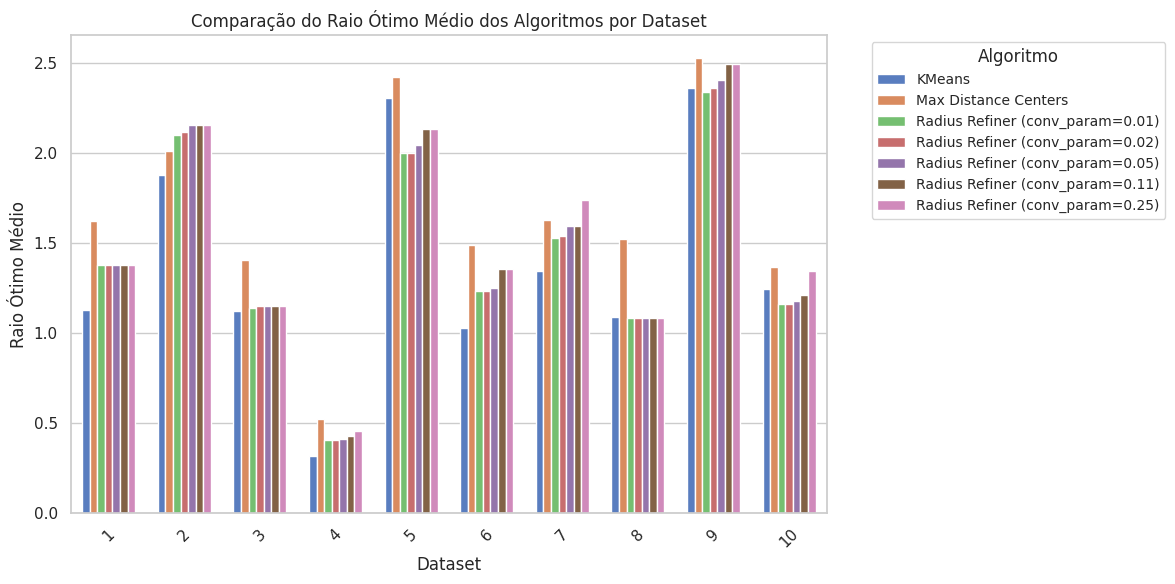

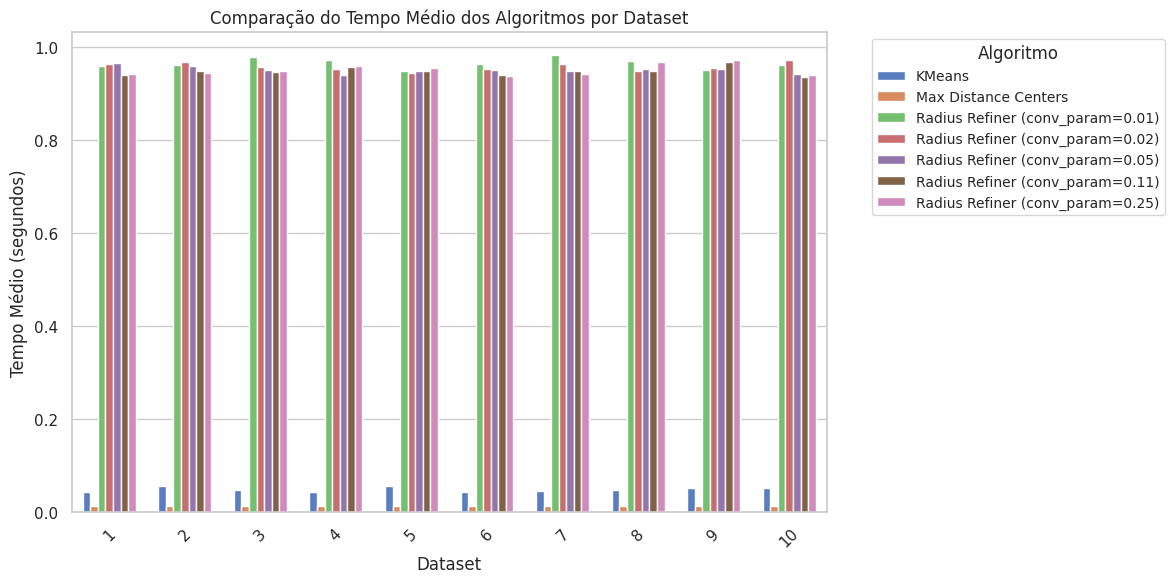

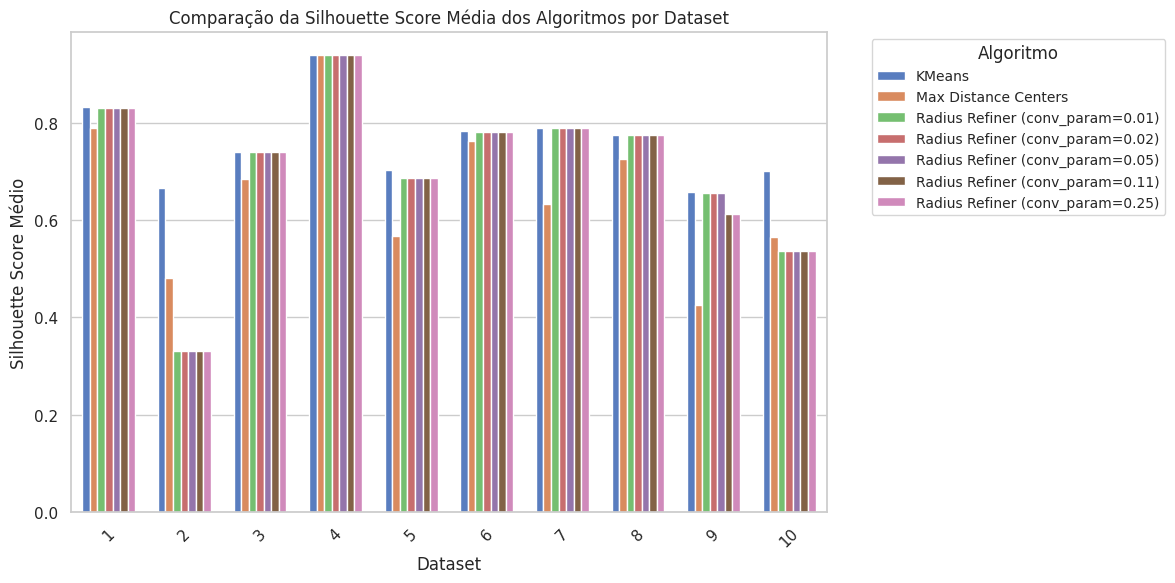

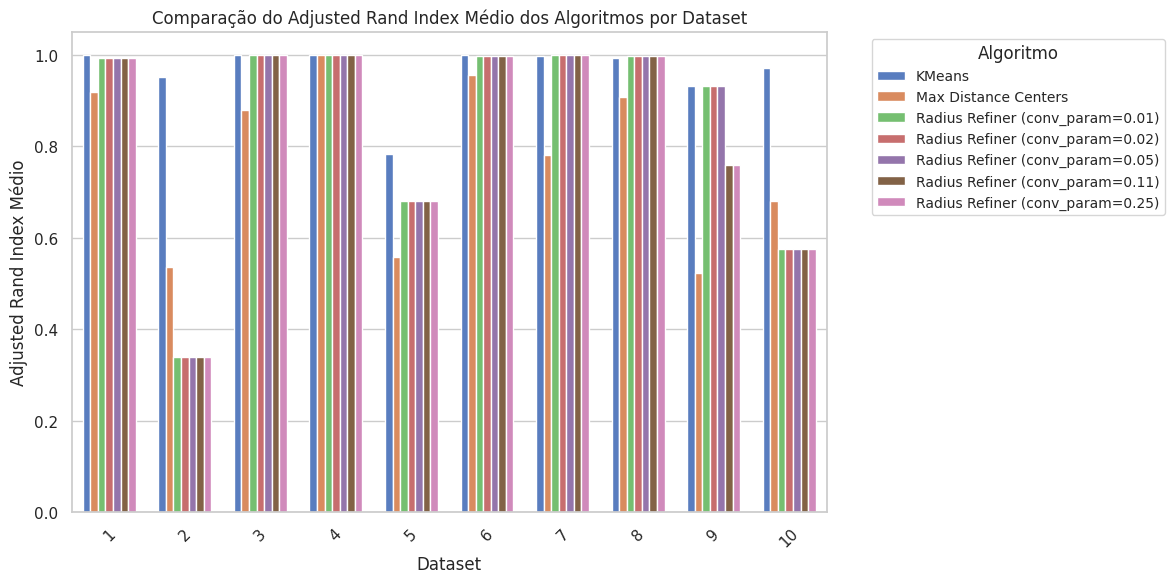

In [ ]:
plot_comparison(result_normal_p2)